## StarTracker Tracking drift check - 28-Mar-23

HyeYun Park - checking calibrated ra and dec during tracking

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time, TimeDelta

from matplotlib.ticker import FormatStrFormatter

In [2]:
# plotting ra and dec vs time with linear fit 
def ra_dec_time_plot(data, start_seq, end_seq):
    days_per_hour = 1/24 * 1/60 * 1/60
    arcsec_per_deg = 60**2
    
    #Selecting range of seq number of one tracking
    calculated_ra = data['Calculated Ra'].values.astype(float)[start_seq: end_seq]
    calculated_dec = data['Calculated Dec'].values.astype(float)[start_seq: end_seq]
    time_array = data['MJD'].values.astype(float)[start_seq: end_seq]
    
    time_mjd = Time(time_array, format='mjd', scale='utc')
    time_mjd.format = 'fits'
    date = time_mjd.strftime('%Y %b %d')[0]
    
    #making linear fit for ra vs time, dec vs time
    coef_ra, cov_ra = np.polyfit(time_array, calculated_ra, 1, cov=True)
    poly1d_fn_ra = np.poly1d(coef_ra) 
    slope_ra = coef_ra[0] * days_per_hour * arcsec_per_deg
    slope_uncertainty_ra = np.sqrt(cov_ra[0, 0]) * days_per_hour * arcsec_per_deg
    
    coef_dec, cov_dec = np.polyfit(time_array, calculated_dec, 1, cov=True)
    poly1d_fn_dec = np.poly1d(coef_dec) 
    slope_dec = coef_dec[0] * days_per_hour * arcsec_per_deg
    slope_uncertainty_dec = np.sqrt(cov_dec[0, 0]) * days_per_hour * arcsec_per_deg
    
    #plotting
    plt.set_loglevel('WARNING')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    fig.subplots_adjust(hspace=0)
    
    ax1.set_title(f'Calculated Ra & Dec {date}, seq num {start_seq}~{end_seq} ', fontsize=16)
    ax1.scatter(time_array, calculated_ra,  s=25)
    ax1.plot(time_array, poly1d_fn_ra(time_array), '--k')
    ax1.set_ylabel('Calculated Ra', fontsize=14)
    ax1.tick_params(axis='x', labelrotation=30)
    ax1.text(x=time_array[len(time_array)//8], y=np.max(calculated_ra),
             s=fr"slope={slope_ra:.4e} $\pm$ {slope_uncertainty_ra:.2e}(arcsec / sec)", bbox=dict(facecolor='white', alpha=0.5))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    ax2.scatter(time_array, calculated_dec, s=25)
    ax2.plot(time_array, poly1d_fn_dec(time_array), '--k')
    xticks = ax2.get_xticks()
    xticklabels_time = Time(xticks, format="mjd", scale="utc")
    clock_time = xticklabels_time.strftime('%H:%M:%S')
    ax2.set_xticks(xticks, labels=clock_time)
    ax2.set_ylabel('Calculated Dec', fontsize=14)
    ax2.set_xlabel('Time (utc)', fontsize=14)
    ax2.text(x=time_array[len(time_array)//8], y=np.max(calculated_dec),
             s=fr"slope={slope_dec:.4e} $\pm$ {slope_uncertainty_dec:.2e}(arcsec / sec)", bbox=dict(facecolor='white', alpha=0.5))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    plt.show(),

In [3]:
dayObs = 20230309
mdFilename = os.path.join('/project/rubintv/starTracker/sidecar_metadata', f'dayObs_{dayObs}.json')
metadata = pd.read_json(mdFilename).T
metadata = metadata.sort_index()

picking the seq number based on the night log 
https://confluence.lsstcorp.org/display/LSSTCOM/23.03.09+StarTracker+Night+Log

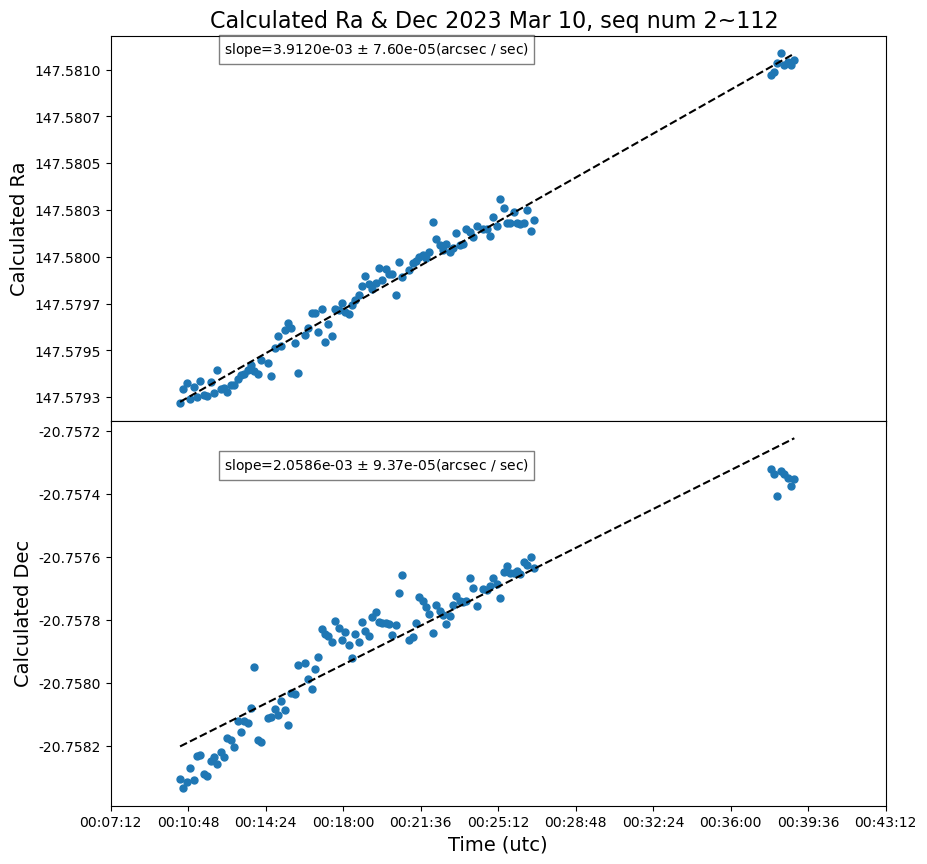

In [4]:
ra_dec_time_plot(metadata, 2, 112)

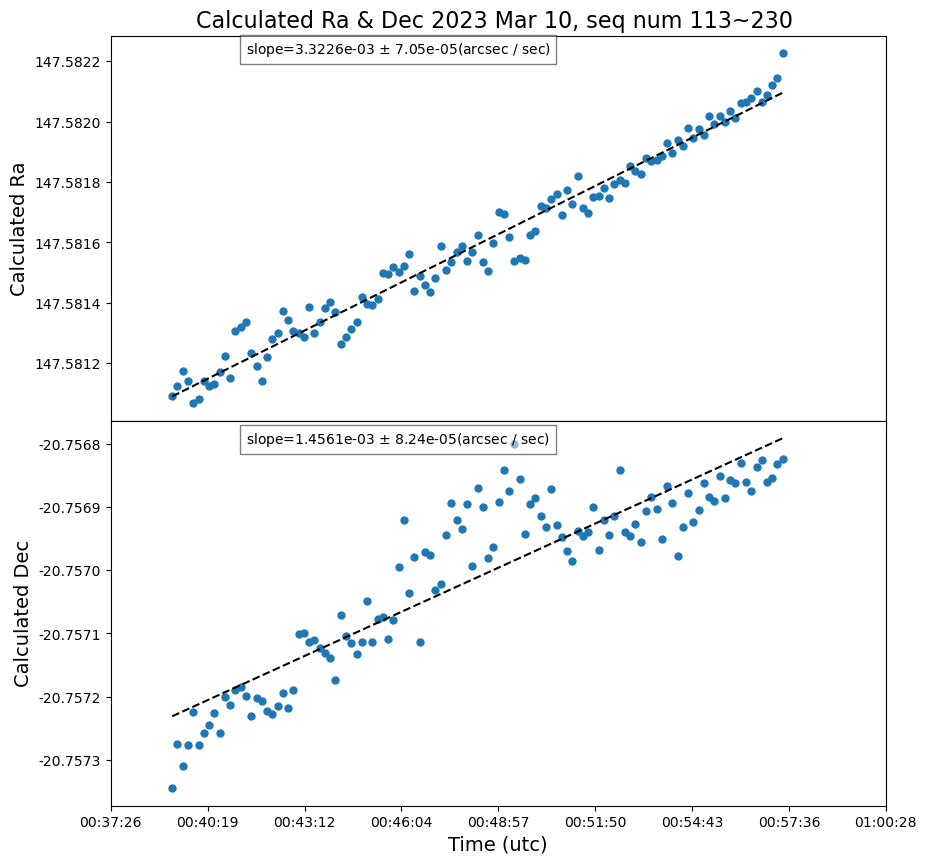

In [5]:
#for seq number 113~230
ra_dec_time_plot(metadata, 113, 230)

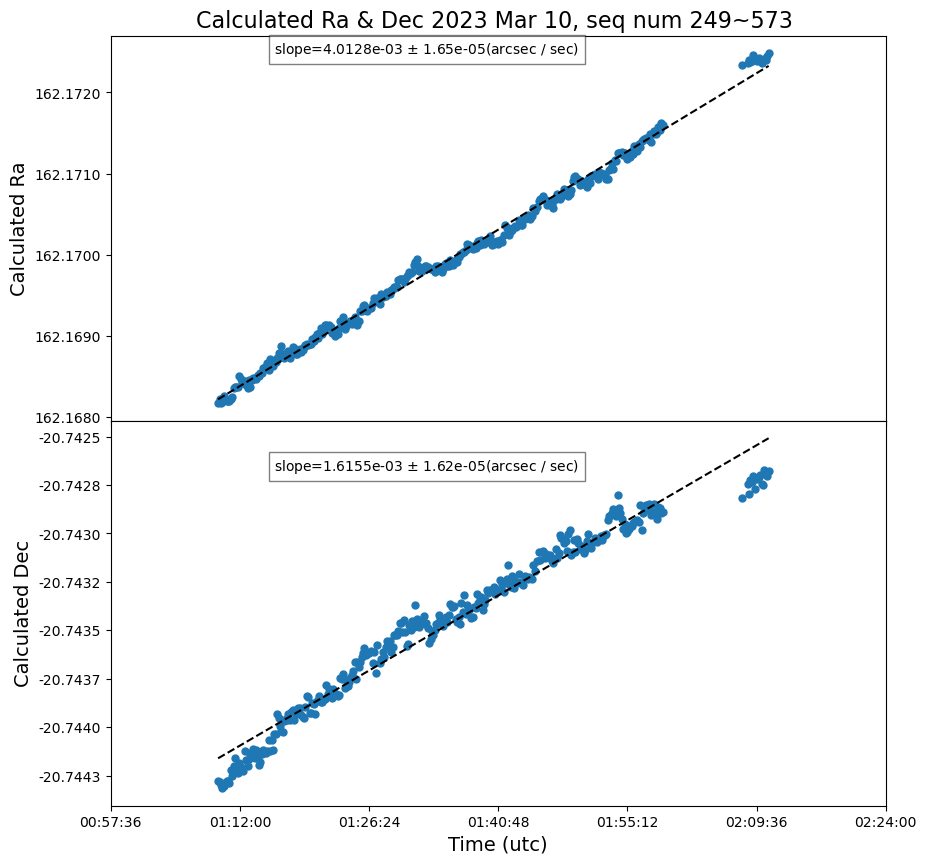

In [6]:
#for seq number 249~573
ra_dec_time_plot(metadata, 249, 573)